In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ardl import ARDL, ardl_select_order
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [2]:
import wbdata
import pandas as pd
import datetime
import pandas_datareader as web
# Define country and date range
country = "DZA"  # Algeria
start_year = 1990
end_year = 2023
date_range = (datetime.datetime(start_year, 1, 1), datetime.datetime(end_year, 12, 31))

# ✅ Updated World Bank indicators
indicators = {
    "NY.GDP.MKTP.KD": "Real_GDP",          # GDP  (constant USD)
    "BX.KLT.DINV.WD.GD.ZS": "FDI_percent_GDP",          # FDI (% of GDP)
    "FP.CPI.TOTL.ZG": "Inflation_consumer_prices",      # Inflation (annual %)
    "NE.EXP.GNFS.ZS": "Exports_percent_GDP",            # Exports (% of GDP)
    "NE.IMP.GNFS.ZS": "Imports_percent_GDP",            # Imports (% of GDP)
    "NE.GDI.TOTL.ZS": "Gross_Capital_Formation_percent_GDP",  # Gross capital formation (% of GDP)
    "PA.NUS.FCRF"   : "Exchange_Rate_LCU_per_USD"         # Exchange rate (LCU per USD)
}

# Fetch data
df = wbdata.get_dataframe(indicators, country=country, date=date_range)

# Clean up
df = df.reset_index()
df["date"] = pd.to_datetime(df["date"], format="%Y")
df = df.sort_values("date")

# Compute Trade Openness (% of GDP)
df["Trade_Openness_percent_GDP"] = df["Exports_percent_GDP"] + df["Imports_percent_GDP"]

# Drop exports/imports columns
df = df.drop(columns=["Exports_percent_GDP", "Imports_percent_GDP"])

# Final cleanup
df = df.sort_values("date").reset_index(drop=True)

# Display preview
print(df.head())




        date      Real_GDP  FDI_percent_GDP  Inflation_consumer_prices  \
0 1990-01-01  9.149723e+10         0.000540                        NaN   
1 1991-01-01  9.039926e+10         0.025459                        NaN   
2 1992-01-01  9.202645e+10         0.062496                        NaN   
3 1993-01-01  9.009389e+10         0.000002                        NaN   
4 1994-01-01  8.928305e+10         0.000002                        NaN   

   Gross_Capital_Formation_percent_GDP  Exchange_Rate_LCU_per_USD  \
0                            28.589421                   8.957508   
1                            31.841327                  18.472875   
2                            30.757489                  21.836075   
3                            29.090908                  23.345407   
4                            30.080143                  35.058501   

   Trade_Openness_percent_GDP  
0                   48.380714  
1                   52.717587  
2                   49.189084  
3           

In [3]:
import pandas as pd

# Load your dataset
df = df

# Convert to datetime
df["date"] = pd.to_datetime(df["date"])

# Extract just the year
df["year"] = df["date"].dt.year

# Drop the original date column (optional)
df = df.drop(columns=["date"])

# Set the year as the index (optional, useful for ARDL)
df = df.set_index("year")

print(df.head())

          Real_GDP  FDI_percent_GDP  Inflation_consumer_prices  \
year                                                             
1990  9.149723e+10         0.000540                        NaN   
1991  9.039926e+10         0.025459                        NaN   
1992  9.202645e+10         0.062496                        NaN   
1993  9.009389e+10         0.000002                        NaN   
1994  8.928305e+10         0.000002                        NaN   

      Gross_Capital_Formation_percent_GDP  Exchange_Rate_LCU_per_USD  \
year                                                                   
1990                            28.589421                   8.957508   
1991                            31.841327                  18.472875   
1992                            30.757489                  21.836075   
1993                            29.090908                  23.345407   
1994                            30.080143                  35.058501   

      Trade_Openness_percent_GDP

In [4]:
import pandas as pd

# Load your datasets
df = df
oil = pd.read_csv("POILBREUSDA.csv")

# Clean columns
oil.columns = [col.strip().lower() for col in oil.columns]

# Rename columns 
if 'observation_date' in oil.columns:
    oil.rename(columns={'observation_date': 'date'}, inplace=True)
if 'poilbreusda' in oil.columns:
    oil.rename(columns={'poilbreusda': 'Oil_Price_USD'}, inplace=True)

# ✅ Convert date correctly (FRED dates like 1980-01-01)
oil['date'] = pd.to_datetime(oil['date'], format='%Y-%m-%d')

# Extract year only for merging
oil['year'] = oil['date'].dt.year

# DATA VECTOR OF INFLATION NANS FROM MACROTRENDS 

manual_inflation = [
    16.65, 
    25.89,
	31.67,
	20.54,
	29.05,
	29.78,
	18.68,
	5.73,
	4.95,
	2.65,
	0.34,
	4.23,
	1.42,
	4.27,
	3.96,
	1.38
]

# Merge by year
merged_df = pd.merge(df, oil[['year', 'Oil_Price_USD']], on='year', how='left')

# Replace NaN values for the first 16 years (assuming the dataframe is sorted by year)
merged_df.loc[:15, 'Inflation_consumer_prices'] = manual_inflation

# Save result
merged_df.to_csv("algeria_fdi_gdp_ardl_with_oil.csv", index=False)

print("✅ Merged successfully! Saved as 'algeria_fdi_gdp_ardl_with_oil.csv'")
print(merged_df.tail())



✅ Merged successfully! Saved as 'algeria_fdi_gdp_ardl_with_oil.csv'
    year      Real_GDP  FDI_percent_GDP  Inflation_consumer_prices  \
29  2019  2.023009e+11         0.713947                   1.951768   
30  2020  1.921858e+11         0.693816                   2.415131   
31  2021  1.994889e+11         0.466728                   7.226063   
32  2022  2.066705e+11         0.107161                   9.265516   
33  2023  2.151440e+11         0.490408                   9.322174   

    Gross_Capital_Formation_percent_GDP  Exchange_Rate_LCU_per_USD  \
29                            44.629562                 119.353558   
30                            42.949358                 126.776800   
31                            39.145805                 135.064058   
32                            35.089120                 141.994975   
33                            37.724946                 135.842933   

    Trade_Openness_percent_GDP  Oil_Price_USD  
29                   46.506843      64.198

In [5]:
merged_df

,year,Real_GDP,FDI_percent_GDP,Inflation_consumer_prices,Gross_Capital_Formation_percent_GDP,Exchange_Rate_LCU_per_USD,Trade_Openness_percent_GDP,Oil_Price_USD
0,1990,9.149723e+10,0.000540,16.650000,28.589421,8.957508,48.380714,23.706614
1,1991,9.039926e+10,0.025459,25.890000,31.841327,18.472875,52.717587,20.075370
2,1992,9.202645e+10,0.062496,31.670000,30.757489,21.836075,49.189084,19.358238
3,1993,9.009389e+10,0.000002,20.540000,29.090908,23.345407,44.922813,17.084759
4,1994,8.928305e+10,0.000002,29.050000,30.080143,35.058501,48.584438,15.959658
5,1995,9.267580e+10,0.000002,29.780000,30.908556,47.662727,55.191005,17.198748
6,1996,9.647551e+10,0.575183,18.680000,25.678414,54.748933,53.705148,20.808530
7,1997,9.753674e+10,0.539670,5.730000,22.446973,57.707350,52.243912,19.310324
8,1998,1.025111e+11,1.258825,4.950000,27.148482,58.738958,45.094451,13.126219
9,1999,1.057915e+11,0.599498,2.650000,26.247685,66.573875,50.929109,18.108219


In [6]:
df = merged_df.copy()
df = df.dropna()   # remove any remaining NaNs
df = df.sort_values('year')
df.set_index('year', inplace=True)


In [7]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Load
df = pd.read_csv("algeria_fdi_gdp_ardl_with_oil.csv")
df['year'] = pd.to_datetime(df['year'], format='%Y')
df.set_index('year', inplace=True)

# Create a copy and apply log ONLY to monetary variables
df_plot = df.copy()
df_plot['log_Real_GDP'] = np.log(df['Real_GDP'])
df_plot['log_Oil_Price_USD'] = np.log(df['Oil_Price_USD'])
df_plot['log_Exchange_Rate'] = np.log(df['Exchange_Rate_LCU_per_USD'])

# Keep original columns for comparison in plots
print("✅ Data loaded. Log versions created for GDP, Oil Price, Exchange Rate.")
print("Variables kept in levels: FDI%, Inflation, GCF%, Trade Openness (%).")



✅ Data loaded. Log versions created for GDP, Oil Price, Exchange Rate.
Variables kept in levels: FDI%, Inflation, GCF%, Trade Openness (%).


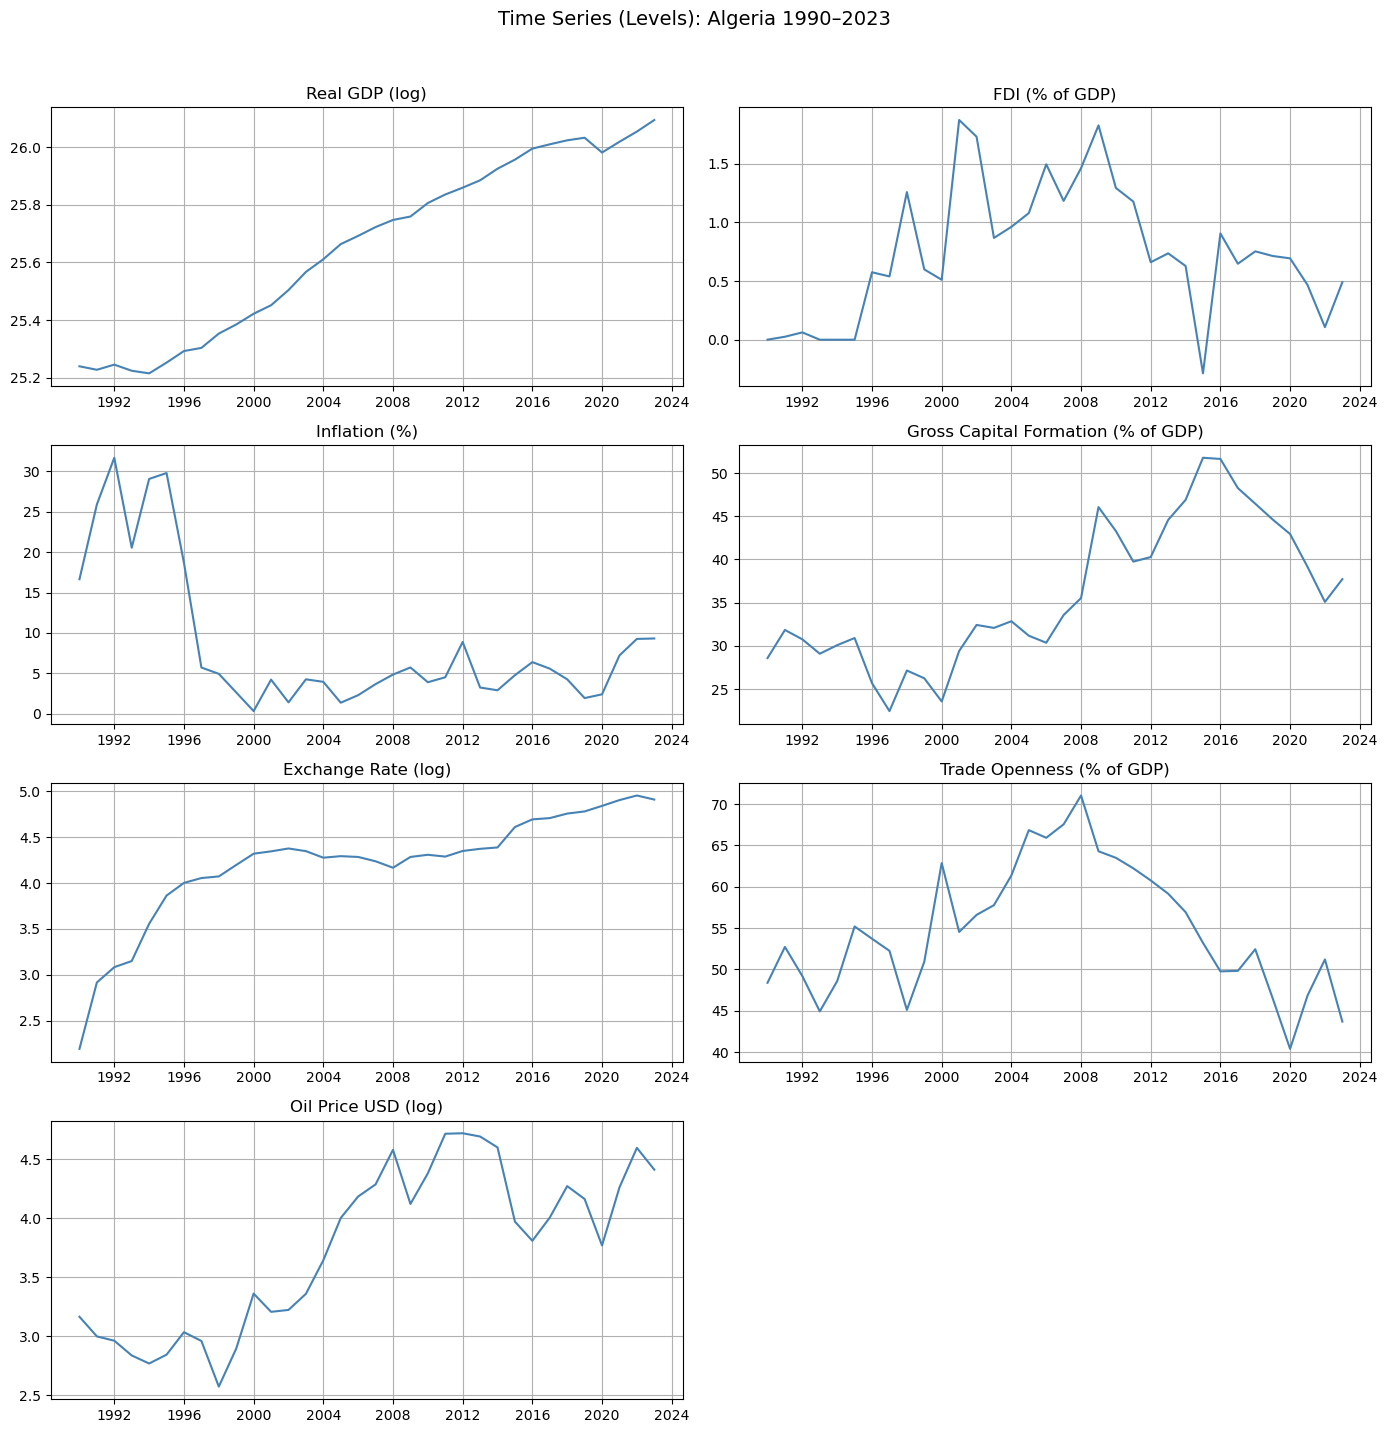

In [8]:
# Define plotting variables: mix of original % and logged monetary
plot_vars = [
    'log_Real_GDP',  # instead of Real_GDP
    'FDI_percent_GDP',
    'Inflation_consumer_prices',
    'Gross_Capital_Formation_percent_GDP',
    'log_Exchange_Rate',  # instead of Exchange_Rate
    'Trade_Openness_percent_GDP',
    'log_Oil_Price_USD'   # instead of Oil_Price_USD
]

titles = [
    'Real GDP (log)',
    'FDI (% of GDP)',
    'Inflation (%)',
    'Gross Capital Formation (% of GDP)',
    'Exchange Rate (log)',
    'Trade Openness (% of GDP)',
    'Oil Price USD (log)'
]

fig, axes = plt.subplots(4, 2, figsize=(14, 14))
axes = axes.flatten()

for i, var in enumerate(plot_vars):
    axes[i].plot(df_plot.index, df_plot[var], color='steelblue')
    axes[i].set_title(titles[i], fontsize=12)
    axes[i].grid(True)

axes[-1].axis('off')
plt.suptitle("Time Series (Levels): Algeria 1990–2023", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

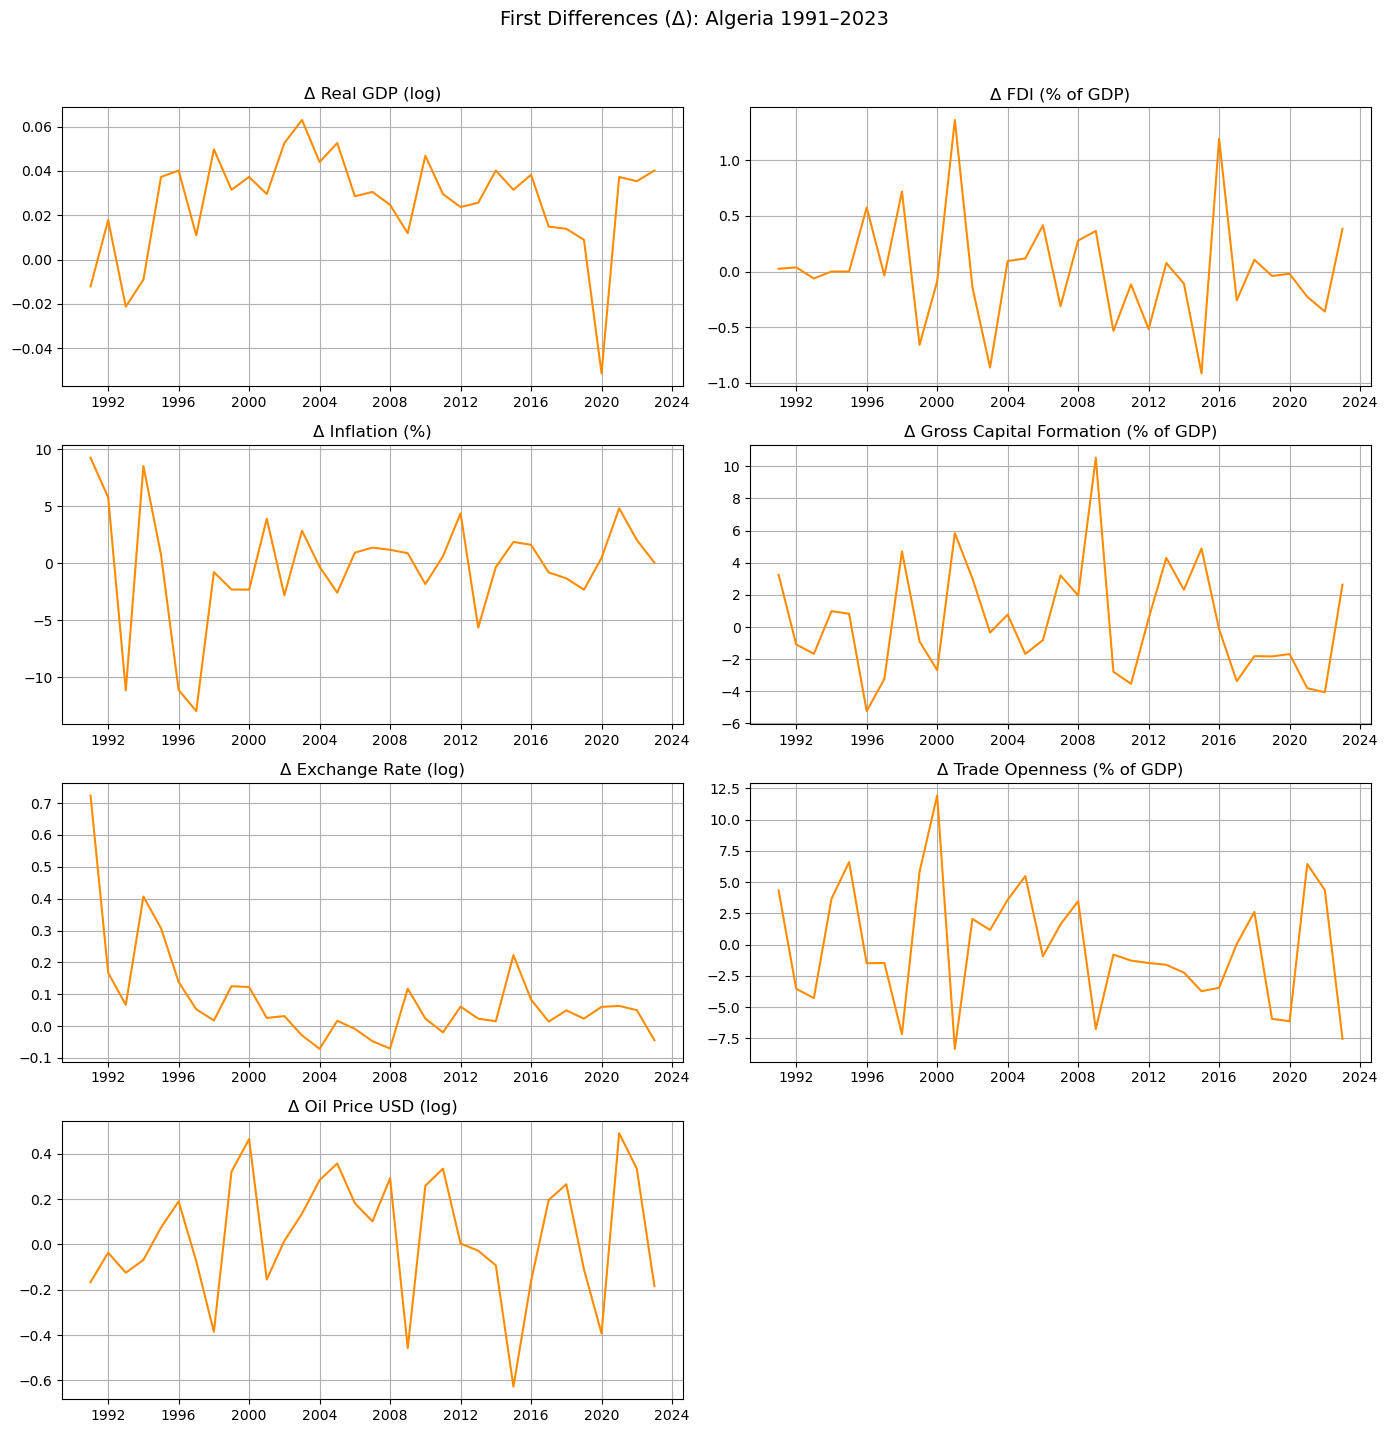

In [9]:
df_diff = df_plot[plot_vars].diff().dropna()

fig, axes = plt.subplots(4, 2, figsize=(14, 14))
axes = axes.flatten()

for i, var in enumerate(plot_vars):
    axes[i].plot(df_diff.index, df_diff[var], color='darkorange')
    axes[i].set_title(f'Δ {titles[i]}', fontsize=12)
    axes[i].grid(True)

axes[-1].axis('off')
plt.suptitle("First Differences (Δ): Algeria 1991–2023", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

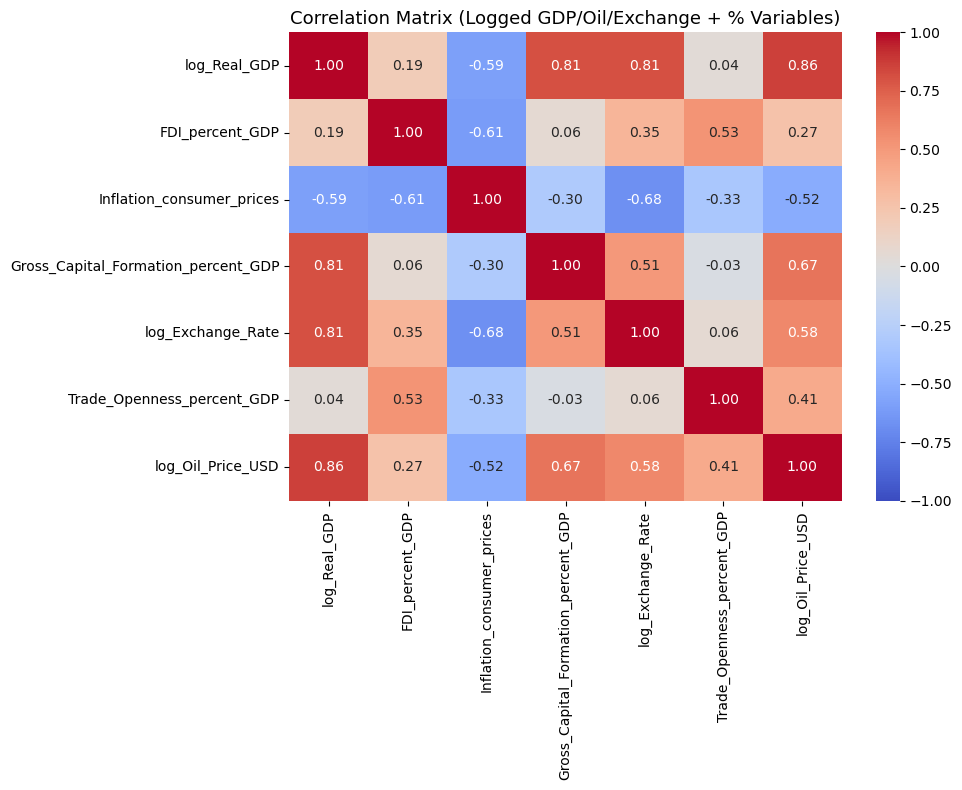

In [10]:
plt.figure(figsize=(10, 8))
corr = df_plot[plot_vars].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Matrix (Logged GDP/Oil/Exchange + % Variables)", fontsize=13)
plt.tight_layout()
plt.show()

In [13]:
print("\n=== ADF TESTS (Using Transformed Data) ===")
results = []

for var in plot_vars:
    # Level
    p_level = adfuller(df_plot[var].dropna(), maxlag=2)[1]
    # First Difference
    p_diff = adfuller(df_plot[var].diff().dropna(), maxlag=2)[1]
    
    order = "I(1)" if p_diff < 0.05 else "⚠️ I(2)?"
    results.append({
        'Variable': var,
        'ADF_p_level': round(p_level, 4),
        'ADF_p_diff': round(p_diff, 4),
        'Integration_Order': order
    })
    print(f"{var:30} | Level p: {p_level:.4f} | Δ p: {p_diff:.4f} → {order}")

# Final check
all_ok = all(r['Integration_Order'] == 'I(1)' for r in results)
print("\n" + "="*60)
if all_ok:
    print("✅ ALL VARIABLES ARE I(1) → ARDL MODEL IS VALID.")
else:
    print("❌ Some variables may be I(2). Re-examine.")


=== ADF TESTS (Using Transformed Data) ===
log_Real_GDP                   | Level p: 0.8859 | Δ p: 0.0005 → I(1)
FDI_percent_GDP                | Level p: 0.0539 | Δ p: 0.0000 → I(1)
Inflation_consumer_prices      | Level p: 0.4301 | Δ p: 0.0000 → I(1)
Gross_Capital_Formation_percent_GDP | Level p: 0.6082 | Δ p: 0.0000 → I(1)
log_Exchange_Rate              | Level p: 0.0098 | Δ p: 0.1876 → ⚠️ I(2)?
Trade_Openness_percent_GDP     | Level p: 0.8250 | Δ p: 0.0000 → I(1)
log_Oil_Price_USD              | Level p: 0.7761 | Δ p: 0.0000 → I(1)

❌ Some variables may be I(2). Re-examine.


In [30]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load and prepare data
df = pd.read_csv("algeria_fdi_gdp_ardl_with_oil.csv")
df['year'] = pd.to_datetime(df['year'], format='%Y')
df.set_index('year', inplace=True)

# Log-transform
df['log_Real_GDP'] = np.log(df['Real_GDP'])
df['log_Oil_Price_USD'] = np.log(df['Oil_Price_USD'])

# Create lagged levels (for long-run equation)
y_l1 = df['log_Real_GDP'].shift(1)
X_l1 = pd.DataFrame({
    'FDI_L1': df['FDI_percent_GDP'].shift(1),
    'Infl_L1': df['Inflation_consumer_prices'].shift(1),
    'GCF_L1': df['Gross_Capital_Formation_percent_GDP'].shift(1),
    'Oil_L1': df['log_Oil_Price_USD'].shift(1),
    'TO_L1': df['Trade_Openness_percent_GDP'].shift(1)
})

# Create dependent: Δy_t
dy = df['log_Real_GDP'].diff()

# Create lagged differences (short-run dynamics)
dy_l1 = dy.shift(1)

dFDI_l1 = df['FDI_percent_GDP'].diff().shift(1)
dOil_l1 = df['log_Oil_Price_USD'].diff().shift(1)
dOil_l2 = df['log_Oil_Price_USD'].diff().shift(2)
dTO_l1 = df['Trade_Openness_percent_GDP'].diff().shift(1)
dTO_l2 = df['Trade_Openness_percent_GDP'].diff().shift(2)

# Assemble full UECM regressors
uecm_df = pd.DataFrame({
    'y_l1': y_l1,
    'FDI_l1': X_l1['FDI_L1'],
    'Infl_L1': X_l1['Infl_L1'],
    'GCF_L1': X_l1['GCF_L1'],
    'Oil_L1': X_l1['Oil_L1'],
    'TO_L1': X_l1['TO_L1'],
    'dy_l1': dy_l1,
    'dFDI_l1': dFDI_l1,
    'dOil_l1': dOil_l1,
    'dOil_l2': dOil_l2,
    'dTO_l1': dTO_l1,
    'dTO_l2': dTO_l2
})

# Add constant
uecm_df['const'] = 1

# Align with Δy and drop NAs
uecm_clean = uecm_df.dropna()
dy_clean = dy.loc[uecm_clean.index]

# Fit UECM
X_uecm = uecm_clean[['const', 'y_l1', 'FDI_l1', 'Infl_L1', 'GCF_L1', 'Oil_L1', 'TO_L1',
                    'dy_l1', 'dFDI_l1', 'dOil_l1', 'dOil_l2', 'dTO_l1', 'dTO_l2']]
uecm_res = sm.OLS(dy_clean, X_uecm).fit()

# Bounds Test: F-test on long-run coefficients (y_l1, FDI_L1, ..., TO_L1) → 6 coefficients including const? No: 5 regressors + y_l1 = 6, but H0: all = 0
# Levels: indices 1 to 6 (y_l1, FDI_L1, Infl_L1, GCF_L1, Oil_L1, TO_L1)
R = np.zeros((6, X_uecm.shape[1]))
R[:, 1:7] = np.eye(6)  # test all level terms

f_test = uecm_res.f_test(R)
F_stat = float(f_test.fvalue)

# Critical values: T ≈ 32, k = 5, case III (intercept, no trend)
I0_lower = 3.06  # I(0) bound
I1_upper = 4.33  # I(1) bound

print("\n" + "="*70)
print("BOUND TEST FOR COINTEGRATION (k=5, dummy excluded from long-run)")
print("="*70)
print(f"F-statistic: {F_stat:.4f}")
print(f"Lower bound (I(0)): {I0_lower}")
print(f"Upper bound (I(1)): {I1_upper}")
if F_stat > I1_upper:
    print("✅ REJECT H0 → COINTEGRATION EXISTS")
elif F_stat < I0_lower:
    print("❌ FAIL TO REJECT H0 → NO COINTEGRATION")
else:
    print("⚠️ INCONCLUSIVE (F-stat between bounds)")
print("="*70)


BOUND TEST FOR COINTEGRATION (k=5, dummy excluded from long-run)
F-statistic: 0.5711
Lower bound (I(0)): 3.06
Upper bound (I(1)): 4.33
❌ FAIL TO REJECT H0 → NO COINTEGRATION


In [29]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import recursive_olsresiduals, het_breuschpagan
from statsmodels.stats.stattools import jarque_bera

# Load and prepare data
df = pd.read_csv("algeria_fdi_gdp_ardl_with_oil.csv")
df['year'] = pd.to_datetime(df['year'], format='%Y')
df.set_index('year', inplace=True)

# Log-transform
df['log_Real_GDP'] = np.log(df['Real_GDP'])
df['log_Oil_Price_USD'] = np.log(df['Oil_Price_USD'])
df['D2020'] = (df.index.year == 2020).astype(int)

# Build EXACT regressors from your final model: ARDL(1,1,0,0,2,2,0)
y = df['log_Real_GDP']
X = df[[
    'FDI_percent_GDP',
    'Inflation_consumer_prices',
    'Gross_Capital_Formation_percent_GDP',
    'log_Oil_Price_USD',
    'Trade_Openness_percent_GDP',
    'D2020'
]]

regs = pd.DataFrame(index=df.index)
regs['GDP_L1'] = y.shift(1)
regs['FDI_L0'] = X['FDI_percent_GDP']
regs['FDI_L1'] = X['FDI_percent_GDP'].shift(1)
regs['Infl_L0'] = X['Inflation_consumer_prices']
regs['GCF_L0'] = X['Gross_Capital_Formation_percent_GDP']
regs['Oil_L0'] = X['log_Oil_Price_USD']
regs['Oil_L1'] = X['log_Oil_Price_USD'].shift(1)
regs['Oil_L2'] = X['log_Oil_Price_USD'].shift(2)
regs['TO_L0'] = X['Trade_Openness_percent_GDP']
regs['TO_L1'] = X['Trade_Openness_percent_GDP'].shift(1)
regs['TO_L2'] = X['Trade_Openness_percent_GDP'].shift(2)
regs['D2020'] = X['D2020']

# Clean data
full = pd.concat([y, regs], axis=1).dropna()
y_ols = full['log_Real_GDP']
X_ols = sm.add_constant(full.drop(columns=['log_Real_GDP']))

# Fit OLS
ols_model = sm.OLS(y_ols, X_ols).fit()

# =============================================================================
# 1. CUSUM Stability Test
# =============================================================================
print("🔍 Running CUSUM Stability Test...")
try:
    recur = recursive_olsresiduals(ols_model, skip=12)  # skip = num regressors
    cusum = np.cumsum(recur[4])
    n = len(cusum)
    s = 1.143 * np.sqrt(n)
    
    plt.figure(figsize=(10, 5))
    plt.plot(cusum, label='CUSUM', color='blue')
    plt.axhline(s, color='red', linestyle='--', label='5% Bounds')
    plt.axhline(-s, color='red', linestyle='--')
    plt.title('CUSUM Stability Test (Final ARDL Model)')
    plt.ylabel('CUSUM')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    if np.any(np.abs(cusum) > s):
        print("⚠️ CUSUM: Model is unstable")
    else:
        print("✅ CUSUM: Model is stable")
except Exception as e:
    print("CUSUM test failed:", str(e))

# =============================================================================
# 2. Heteroskedasticity (Breusch-Pagan)
# =============================================================================
print("\n📊 Breusch-Pagan Heteroskedasticity Test")
bp_lm, bp_p, _, _ = het_breuschpagan(ols_model.resid, ols_model.model.exog)
print(f"p-value: {bp_p:.4f} → {'✅ Homoskedastic' if bp_p > 0.05 else '❌ Heteroskedastic'}")

# =============================================================================
# 3. Normality (Jarque-Bera)
# =============================================================================
print("\n📊 Jarque-Bera Normality Test")
jb_stat, jb_p, _, _ = jarque_bera(ols_model.resid)
print(f"p-value: {jb_p:.4f} → {'✅ Normal' if jb_p > 0.05 else '❌ Non-normal'}")

# =============================================================================
# 4. Short-Run Summary (Only Valid Interpretation)
# =============================================================================
print("\n" + "="*60)
print("SHORT-RUN DYNAMIC EFFECTS (Final Model)")
print("="*60)
short_run_vars = ['FDI_L1', 'Oil_L2', 'TO_L2', 'D2020']
for var in short_run_vars:
    if var in ols_model.params:
        coef = ols_model.params[var]
        pval = ols_model.pvalues[var]
        sig = "✅" if pval < 0.05 else ("⚠️" if pval < 0.10 else "❌")
        print(f"{var:12} = {coef:8.6f} (p={pval:.4f}) {sig}")

🔍 Running CUSUM Stability Test...
CUSUM test failed: "The initial regressor matrix, x[:skip], issingular. You must use a value of
skip large enough to ensure that the first OLS estimator is well-defined.


📊 Breusch-Pagan Heteroskedasticity Test
p-value: 0.5592 → ✅ Homoskedastic

📊 Jarque-Bera Normality Test
p-value: 0.3217 → ✅ Normal

SHORT-RUN DYNAMIC EFFECTS (Final Model)
FDI_L1       = 0.015741 (p=0.0992) ⚠️
Oil_L2       = 0.075574 (p=0.0028) ✅
TO_L2        = -0.004122 (p=0.0066) ✅
D2020        = -0.078327 (p=0.0005) ✅


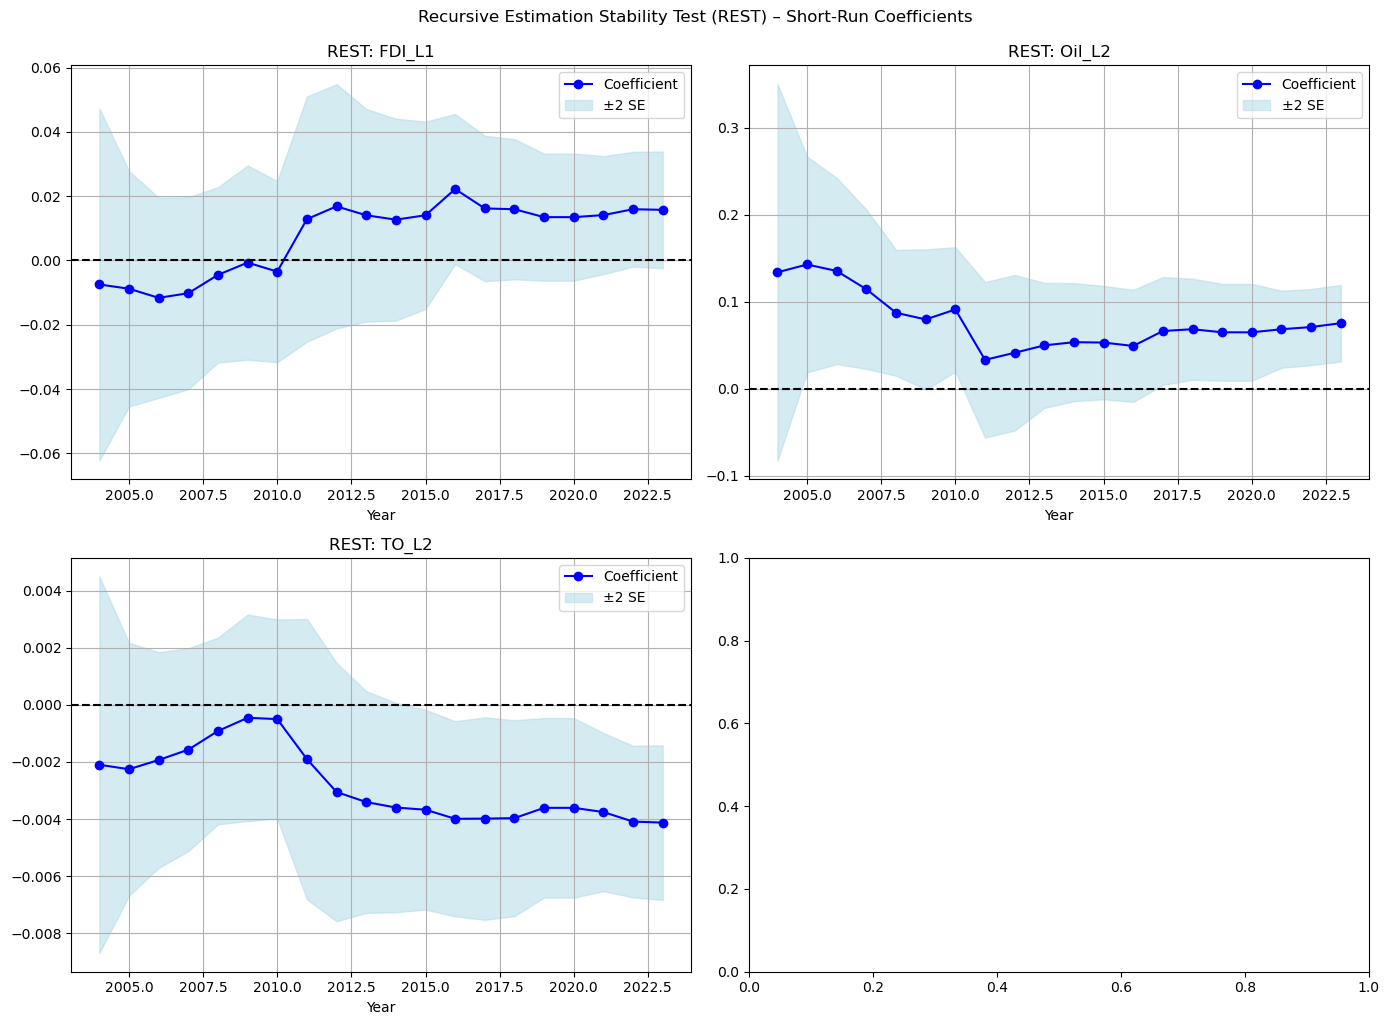


🔍 REST Stability Assessment (Final vs. Early Estimates):
FDI_L1    : Final = 0.0157 → ✅ Stable
Oil_L2    : Final = 0.0756 → ✅ Stable
TO_L2     : Final = -0.0041 → ⚠️ Unstable


In [25]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.ardl import ARDL

# Load data
df = pd.read_csv("algeria_fdi_gdp_ardl_with_oil.csv")
df['year'] = pd.to_datetime(df['year'], format='%Y')
df.set_index('year', inplace=True)

# Log-transform
df['log_Real_GDP'] = np.log(df['Real_GDP'])
df['log_Oil_Price_USD'] = np.log(df['Oil_Price_USD'])
df['D2020'] = (df.index.year == 2020).astype(int)

# Final lag structure from your output
y = df['log_Real_GDP']
X = df[[
    'FDI_percent_GDP',
    'Inflation_consumer_prices',
    'Gross_Capital_Formation_percent_GDP',
    'log_Oil_Price_USD',
    'Trade_Openness_percent_GDP',
    'D2020'
]]

# Define recursive window
min_obs = 15  # Minimum observations to start (must be > #parameters)
n_total = len(df)
results = []

for t in range(min_obs, n_total + 1):
    try:
        # Subset data
        y_sub = y.iloc[:t]
        X_sub = X.iloc[:t]
        
        # Estimate ARDL(1,1,0,0,2,2,0) on subset
        order_dict = {
            'FDI_percent_GDP': 1,
            'Inflation_consumer_prices': 0,
            'Gross_Capital_Formation_percent_GDP': 0,
            'log_Oil_Price_USD': 2,
            'Trade_Openness_percent_GDP': 2,
            'D2020': 0
        }
        model = ARDL(
            endog=y_sub,
            lags=1,
            exog=X_sub,
            order=order_dict,
            trend='c',
            missing='drop'
        ).fit()
        
        # Extract key coefficients
        coef_dict = {
            'FDI_L1': model.params.get('FDI_percent_GDP.L1', np.nan),
            'Oil_L2': model.params.get('log_Oil_Price_USD.L2', np.nan),
            'TO_L2': model.params.get('Trade_Openness_percent_GDP.L2', np.nan),
            'D2020': model.params.get('D2020', np.nan),
            'GDP_L1': model.params.get('log_Real_GDP.L1', np.nan)
        }
        se_dict = {
            'FDI_L1': model.bse.get('FDI_percent_GDP.L1', np.nan),
            'Oil_L2': model.bse.get('log_Oil_Price_USD.L2', np.nan),
            'TO_L2': model.bse.get('Trade_Openness_percent_GDP.L2', np.nan),
            'D2020': model.bse.get('D2020', np.nan),
            'GDP_L1': model.bse.get('log_Real_GDP.L1', np.nan)
        }
        results.append({
            'year': df.index[t-1].year,
            **coef_dict,
            **{k+'_se': v for k, v in se_dict.items()}
        })
    except:
        # Skip if estimation fails
        results.append({
            'year': df.index[t-1].year,
            'FDI_L1': np.nan, 'Oil_L2': np.nan, 'TO_L2': np.nan, 'D2020': np.nan, 'GDP_L1': np.nan,
            'FDI_L1_se': np.nan, 'Oil_L2_se': np.nan, 'TO_L2_se': np.nan, 'D2020_se': np.nan, 'GDP_L1_se': np.nan
        })

# Convert to DataFrame
rest_df = pd.DataFrame(results).set_index('year')

# Plot REST for key short-run coefficients
vars_to_plot = ['FDI_L1', 'Oil_L2', 'TO_L2']  # Remove 'D2020'

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    coef = rest_df[var]
    se = rest_df[var + '_se']
    years = coef.index
    
    axes[i].plot(years, coef, 'bo-', label='Coefficient')
    axes[i].fill_between(years, coef - 2*se, coef + 2*se, color='lightblue', alpha=0.5, label='±2 SE')
    axes[i].axhline(0, color='black', linestyle='--')
    axes[i].set_title(f'REST: {var}')
    axes[i].set_xlabel('Year')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.suptitle('Recursive Estimation Stability Test (REST) – Short-Run Coefficients', y=1.02)
plt.show()

# Summary: Check if final coefficient is within early confidence bands
print("\n🔍 REST Stability Assessment (Final vs. Early Estimates):")
for var in vars_to_plot:
    final_coef = rest_df[var].iloc[-1]
    early_upper = rest_df[var + '_se'].iloc[5] * 2 + rest_df[var].iloc[5]
    early_lower = rest_df[var].iloc[5] - rest_df[var + '_se'].iloc[5] * 2
    stable = early_lower <= final_coef <= early_upper
    print(f"{var:10}: Final = {final_coef:.4f} → {'✅ Stable' if stable else '⚠️ Unstable'}")
  